flushing temporary and output files...
done.
NOTE: Since in DEBUG mode, Will reprocess files if instructed.
in ipynb, staging_dir is: /lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring_staging/20181023
  20181023 considered to be a dir.
   In dir, pathname: /lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring_staging/20181023/20181023/, dirfile: SDR_SpectrumPeak.20181023-140000.n120.None.ridz
List of unprocessed files (or all files if DEBUG): ['SDR_SpectrumPeak.20181023-140000.n120.None.ridz']
Ready to analyze files in pathname "/lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring_staging/20181023/20181023/".
launching subprocess...
Need to properly do this, but for now = 0.0
Reading SDR_SpectrumPeak.20181019-160630.n8.None.ridz
Data span 2018-10-19 16:06:30 - 2018-10-19 16:10:00


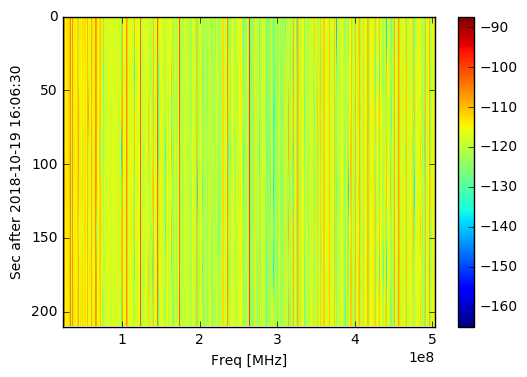

Need to properly do this, but for now = 0.0
Reading SDR_SpectrumPeak.20181019-160630.n8.None.ridz
Data span 2018-10-19 16:06:30 - 2018-10-19 16:10:00


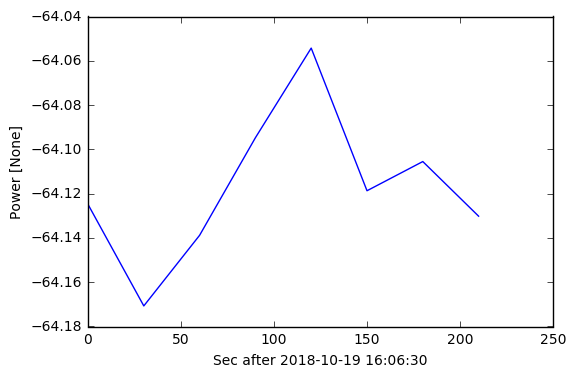

    ...subprocess complete.


"\nplt.figure(1, figsize=(20,10))\nplt.subplot(211)\nif (np.size(arr_day) !=0): \n    plt.plot(arr_day[:,0], arr_day[:,1],'bo')\nelse:\n    plt.subplot(211).set_title(str('Nighttime Integrated Power: '+str(  np.round(sum_array_of_dbm(arr_night[:,1]),decimals=1)  )+' dBm'))\nif (np.size(arr_night) !=0): \n    plt.plot(arr_night[:,0], arr_night[:,1],'go')\nelse: \n    plt.subplot(211).set_title(str('Daytime Integrated Power: '+str(  np.round(sum_array_of_dbm(arr_day[:,1]),decimals=1)  )+' dBm'))\nif (np.size(arr_day) !=0) and (np.size(arr_night) !=0): plt.subplot(211).set_title(str('Daytime ('+str(delta_hour)+' Hours, '+str(delta_minute)+' Minutes) Integrated Power: '+str(  np.round(sum_array_of_dbm(arr_day[:,1]),decimals=1) )+ 'dBm, Nighttime Integrated Power: '+str(  np.round(sum_array_of_dbm(arr_night[:,1]),decimals=1)  )+' dBm'))\nplt.subplot(212)\nplt.plot(arr_full_day[:,0], arr_full_day[:,1],'ro')\nplt.subplot(212).set_title(str('Full 24 Hours, Average Integrated Power: ' + str(  n

In [1]:
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import os
import json
import subprocess

OUT_DAY = 'arr_day.npy' #the output files containing integrated power and metadata for each sweep-spectrum on record
OUT_NIGHT = 'arr_night.npy'
#DATA_PATH = #
SUNSET_TIMETABLE = np.genfromtxt('/lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring/HERA_daily_RFI/HERA_sunrise_sunset_annual.csv', dtype=str,delimiter=',') # Col 0: Month-day (mmdd), Col 1: Sunrise (hhmm), Col 2: Sunset (hhmm)
STR_DAY = os.environ['which_day']
DEBUG = True

def file_flush():
	if DEBUG: print('flushing temporary and output files...')
	open(OUT_DAY, 'w').close()
	open(OUT_NIGHT, 'w').close()
	if DEBUG: print('done.')

def delta_hours_minutes(td):
    return td.seconds//3600, (td.seconds//60)%60

def recursive_key_search(dat, key): #https://stackoverflow.com/questions/9807634/find-all-occurrences-of-a-key-in-nested-python-dictionaries-and-lists
#sum_dbm_recursive_key_search(dat, key): #https://stackoverflow.com/questions/9807634/find-all-occurrences-of-a-key-in-nested-python-dictionaries-and-lists
    if key in dat:
        yield dat[key]
    for k in dat:
        if isinstance(dat[k], list):
            for i in dat[k]:
                for j in recursive_key_search(i):
                    yield j

def time_in_rids_fmt(datetime_time): # convert datetime.datetime.now() time into the RIDZ-requested format
	str_iso = datetime_time.isoformat(' ')
	str_time_rids = str( str_iso[0:4] + str_iso[5:7] + str_iso[8:10] + '-' + str_iso[11:13]+str_iso[14:16]+str_iso[17:19])
	return str_time_rids

def sum_array_of_dbm(arr):
	val_sum = 10.*np.log10(np.sum(np.power(10,np.array(arr)/10.)))
	return val_sum

def trunc_time(dt):
    dt_trunc = datetime.date(dt.day, dt.hour, dt.minute, dt.second)
    return dt_trunc
  

def day_night_initial_calculation(arr_day,arr_night):
    ## connect to librarian
    #cl = LibrarianClient(connection_name)

    ## search for unprocessed sessions
    #files = cl.search_files(search)['results']

    #if not len(sessions):
    #    return # Nothing to do.

    #plot_script = os.path.join(plots_dir, 'run_notebook.sh')

    ## check these fileid aren't in the processed_sessid.txt file
    processed_file_dir = os.path.dirname(os.environ['DATA_PATH'])
    processed_fileid = np.loadtxt(os.path.join(processed_file_dir, 'processed_fileid.txt'), dtype=np.int)
    if DEBUG: 
        print('NOTE: Since in DEBUG mode, Will reprocess files if instructed.')
        
    # filter out sessions already processed
    unprocessed_files = []
    pathname = []
    for diritem in os.listdir(os.environ['staging_dir']):
        if DEBUG: 
            print('in ipynb, staging_dir is: '+str(os.environ['staging_dir']))
        if os.path.isdir(diritem) or str(diritem).isdigit():
            pathname = str(str(os.environ['staging_dir'])+'/'+str(diritem)+'/')
            print('  '+str(diritem)+' considered to be a dir.')
            for dir_file in os.listdir(pathname):
                name=str(dir_file)#file["name"])
                if DEBUG: print('   In dir, pathname: '+str(pathname)+', dirfile: '+str(name))
                fileid = int(name[int(name.find('.')+1):name.find('-')])
                if (fileid not in processed_fileid) or DEBUG:
                    unprocessed_files.append(name)
        else:
            pathname = str(os.environ['staging_dir']+'/')
            if DEBUG: 
                name=str(diritem)#file["name"])
                print('  '+str(name)+' is thought to be a file, not a directory.')
            print('    diritem is a file, name: '+str(name))
            fileid = int(name[int(name.find('.')+1):name.find('-')])
            if (fileid not in processed_fileid) or DEBUG:
                unprocessed_files.append(name)

    #cwd = os.getcwd()
    if DEBUG: 
        print('List of unprocessed files (or all files if DEBUG): '+str(unprocessed_files))
        print('Ready to analyze files in pathname "'+str(pathname)+'".')
    print('launching subprocess...')
    #subprocess.call([str('sp_rawview.py --wf val ' + str(','.join([str(s) for s in os.listdir(pathname) if s.endswith('.ridz') and str(STR_DAY) in s])))], shell =True)
    str_args = [str( ','.join([str(s) for s in os.listdir(os.getcwd()) if s.endswith('.ridz') and STR_DAY in s]))]
    str_wf = ["--wf val"]
    %run ~/anaconda/envs/py2.7env/bin/sp_rawview --wf val SDR_SpectrumPeak.20181019-160630.n8.None.ridz
    %run ~/anaconda/envs/py2.7env/bin/sp_rawview --totalpower val SDR_SpectrumPeak.20181019-160630.n8.None.ridz
    print('    ...subprocess complete.')
    #for filename in os.listdir(pathname):
        #if DEBUG: print('filename: '+str(filename))
        #if str(filename) in unprocessed_files:
            
        #print('arr_day: '+str(arr_day))
        #print('arr_night: '+str(arr_night))
    return arr_day, arr_night

#For the day in question, figure out when sunset and sunrise were. 
col_date,col_key = np.where(SUNSET_TIMETABLE == STR_DAY[4:]) #find mmdd, but it could also be a time
sunrise = datetime.datetime.strptime( str(str(STR_DAY[:4])+str(STR_DAY[4:])+'-'+str(SUNSET_TIMETABLE[int(col_date[col_key==0])][1])) ,'%Y%m%d-%H%M')
sunset = datetime.datetime.strptime( str(str(STR_DAY[:4])+str(STR_DAY[4:])+'-'+str(SUNSET_TIMETABLE[int(col_date[col_key==0])][2])) ,'%Y%m%d-%H%M')
delta_hour, delta_minute = delta_hours_minutes((sunset-sunrise))
#Arrays containing data from each sweep measurement, sorted by whether the data occured in the daytime or nighttime.
arr_day=[] # [datetime.datetime object], [float(integrated power)]
arr_night=[]


file_flush() # Make sure output files aren't reused with old data in them.
arr_day, arr_night = day_night_initial_calculation(arr_day,arr_night)

#Turn the array of arrays into a 2D array
arr_day=np.array(arr_day)
arr_night = np.array(arr_night)

'''
if DEBUG: 
    print('arr_day shape: ' +str(np.shape(arr_day)))
    print('arr_night shape: ' +str(np.shape(arr_night)))
'''
np.save(OUT_DAY,arr_day)
np.save(OUT_NIGHT,arr_night)

'''
if DEBUG: 
    print('arr_day: '+str(arr_day))
    print('arr_day[0,0]: '+str(arr_day[0,0]))
    print('arr_day[:,0]: '+str(arr_day[:,0]))
'''   
arr_full_day = []

if (np.size(arr_day) !=0) and (np.size(arr_night) !=0): arr_full_day = np.concatenate((np.array(arr_day), np.array(arr_night)),axis=0)
elif (np.size(arr_day) ==0): arr_full_day = arr_night
else: arr_full_day = arr_day
'''
plt.figure(1, figsize=(20,10))
plt.subplot(211)
if (np.size(arr_day) !=0): 
    plt.plot(arr_day[:,0], arr_day[:,1],'bo')
else:
    plt.subplot(211).set_title(str('Nighttime Integrated Power: '+str(  np.round(sum_array_of_dbm(arr_night[:,1]),decimals=1)  )+' dBm'))
if (np.size(arr_night) !=0): 
    plt.plot(arr_night[:,0], arr_night[:,1],'go')
else: 
    plt.subplot(211).set_title(str('Daytime Integrated Power: '+str(  np.round(sum_array_of_dbm(arr_day[:,1]),decimals=1)  )+' dBm'))
if (np.size(arr_day) !=0) and (np.size(arr_night) !=0): plt.subplot(211).set_title(str('Daytime ('+str(delta_hour)+' Hours, '+str(delta_minute)+' Minutes) Integrated Power: '+str(  np.round(sum_array_of_dbm(arr_day[:,1]),decimals=1) )+ 'dBm, Nighttime Integrated Power: '+str(  np.round(sum_array_of_dbm(arr_night[:,1]),decimals=1)  )+' dBm'))
plt.subplot(212)
plt.plot(arr_full_day[:,0], arr_full_day[:,1],'ro')
plt.subplot(212).set_title(str('Full 24 Hours, Average Integrated Power: ' + str(  np.round(sum_array_of_dbm(arr_full_day[:,1]),decimals=1)  )+' dBm'))
plt.gcf().autofmt_xdate()
 
plt.show()
'''